# Bayesian Flow Networks for discretized MNIST
In this notebook, we demonstrate how [Bayesian Flow Networks](https://arxiv.org/abs/2308.07037) (BFN) can be used to generate samples similar to data from the discretized MNIST.

## Library imports
This notebook uses the Pytorch EMA module. If it is not installed yet on your machine, run the following command:
```bash
pip install torch-ema
```

In [310]:
import os
import random
from math import inf

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_ema
import torchvision
import torchvision.transforms as transforms
from torch.nn.functional import relu
from torch.optim import AdamW
from torchsummary import summary
from tqdm.auto import tqdm

## Preliminary code
In this section we define useful variables and functions that we will need later in the notebook.

The following cell defines global variables that are used in this notebook. You can change their values to configure the notebook to your preferences. <br>
Here is a synthetic description of each of these variables:
- `DATAPATH`: path to the folder where the various datasets are stored.
- `SEED`: seed used to initialize all random number generators. If set to `None`, the results are non reproducible.
- `DEVICE`: device on which the computations will happen (`"cpu"` or `"cuda"`). Set automatically based on GPU availability, change to a specific device manually if you are facing issues.
- `SAVE_MODEL`: weither to save to trained models or not. If set to `True` and a model has already been saved, training process will be skipped and the saved model will be used instead.
- `MODELS_PATH`: path to the folder where the models are stored.

In [311]:
DATAPATH = "../datasets/"
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_MODEL = True
MODELS_PATH = "./ckpt_discrete/mnist"

In [312]:
print(f"Using device: {DEVICE}")

Using device: cuda


In [313]:
%matplotlib inline

"""
Publication ready pyplot theme
Source: https://github.com/matplotlib/matplotlib/issues/19028
"""

plot_settings = {'ytick.labelsize': 16,
                 'xtick.labelsize': 16,
                 'font.size': 22,
                 'figure.figsize': (10, 5),
                 'axes.titlesize': 22,
                 'axes.labelsize': 18,
                 'lines.linewidth': 2,
                 'lines.markersize': 3,
                 'legend.fontsize': 11,
                 'mathtext.fontset': 'stix',
                 'font.family': 'STIXGeneral'}
plt.style.use(plot_settings)

In [314]:
if SEED:
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.use_deterministic_algorithms(True)

In [315]:
def get_sample(dataloader: torch.utils.data.DataLoader) -> tuple[torch.Tensor, int]:
    """
    Returns a random sample from a data loader

    Args:
        dataloader (torch.utils.data.DataLoader): data loader storing the images.

    Returns:
        tuple[torch.Tensor, int]: (image, label)
    """
    for sample in dataloader:
        return sample[0], sample[1][0].numpy()
    raise IndexError("Could not sample an empty data loader.")
    
def show_samples(dataloader: torch.utils.data.DataLoader, n: int, title: str=None) -> None:
    """
    Displays some random samples from a data loader.

    Args:
        dataloader (torch.utils.data.DataLoader): data loader storing the images.
        n (int): number of samples to display.
    """
    fig, ax = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        img, label = get_sample(dataloader)
        ax[i].imshow(img[0][0], cmap='Greys_r', interpolation='nearest')
        ax[i].set_title(label)
        ax[i].axis("off")
    title = title if title else f"{n} random samples"
    fig.suptitle(title, position=(0.5, 1.1))
    
def moving_average(data: list[float], window_size: int=20) -> list[float]:
    """
    Computes the moving average of a list of values.

    Args:
        data (list[float]): list of values.
        window_size (int, optional): length of the window over which the values will be averaged out. Defaults to 20.

    Returns:
        list[float]: list of averaged values.
    """
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        avg = sum(window) / window_size
        moving_avg.append(avg)
    return moving_avg

## Data import
In this section we define the code that imports and discretizes the MNIST dataset to build training and testing data loaders (respectively `train_loader` and `test_loader`).

In [316]:
# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to [-1, 1]
    #transforms.Lambda(lambda x: torch.round((x + 1) / 2).to(torch.int64)) # Discretize data
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATAPATH, train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATAPATH, train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [317]:
class DynamicallyBinarizedMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(DynamicallyBinarizedMNIST, self).__init__(root, train=train, transform=transform,
                                                        target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, target

def collate_dynamic_binarize(batch: list[tuple[torch.Tensor, int]]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Collate function that samples a binarization probability for each batch.

    Args:
        batch (list[tuple[torch.Tensor, int]]): list of samples to collate.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: resulting batch.
    """
    images, targets = zip(*batch)
    binarization_probs = torch.rand(len(images))
    binarized_images = []
    for img, prob in zip(images, binarization_probs):
        binarized_img = (img > prob).float()
        binarized_images.append(binarized_img)
    return torch.stack(binarized_images)[:, None, ...].to(torch.int64), torch.tensor(targets)

# Create the dynamically binarized MNIST dataset
train_dataset = DynamicallyBinarizedMNIST(root=DATAPATH, train=True, download=True) # transform=transform
test_dataset = DynamicallyBinarizedMNIST(root=DATAPATH, train=False, download=True) # transform=transform

# Create data loaders with the collate function
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_dynamic_binarize)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_dynamic_binarize)


Number of data points in the training dataset: 118
Number of data points in the test dataset: 20


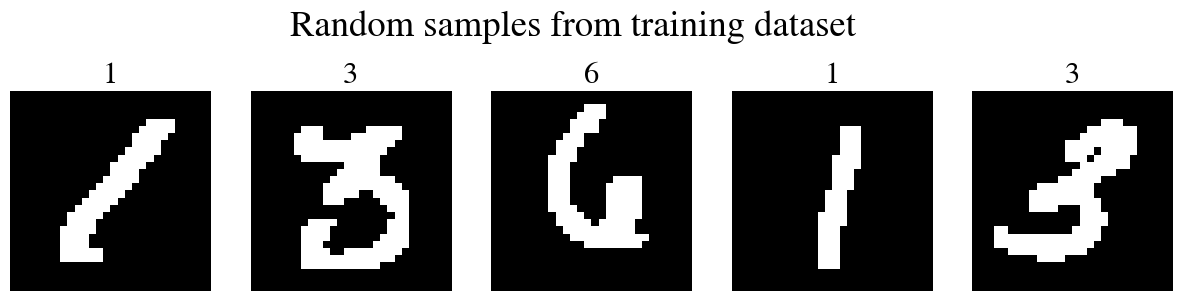

In [318]:
print(f"Number of data points in the training dataset: {len(train_loader)}")
print(f"Number of data points in the test dataset: {len(test_loader)}")
show_samples(train_loader, 5, "Random samples from training dataset")

## Model definition

### Intermediary model
We start by defining the convolutional model. For this project we use a simplified version of the [U-Net](http://arxiv.org/abs/1505.04597) architecture, with the following structure:

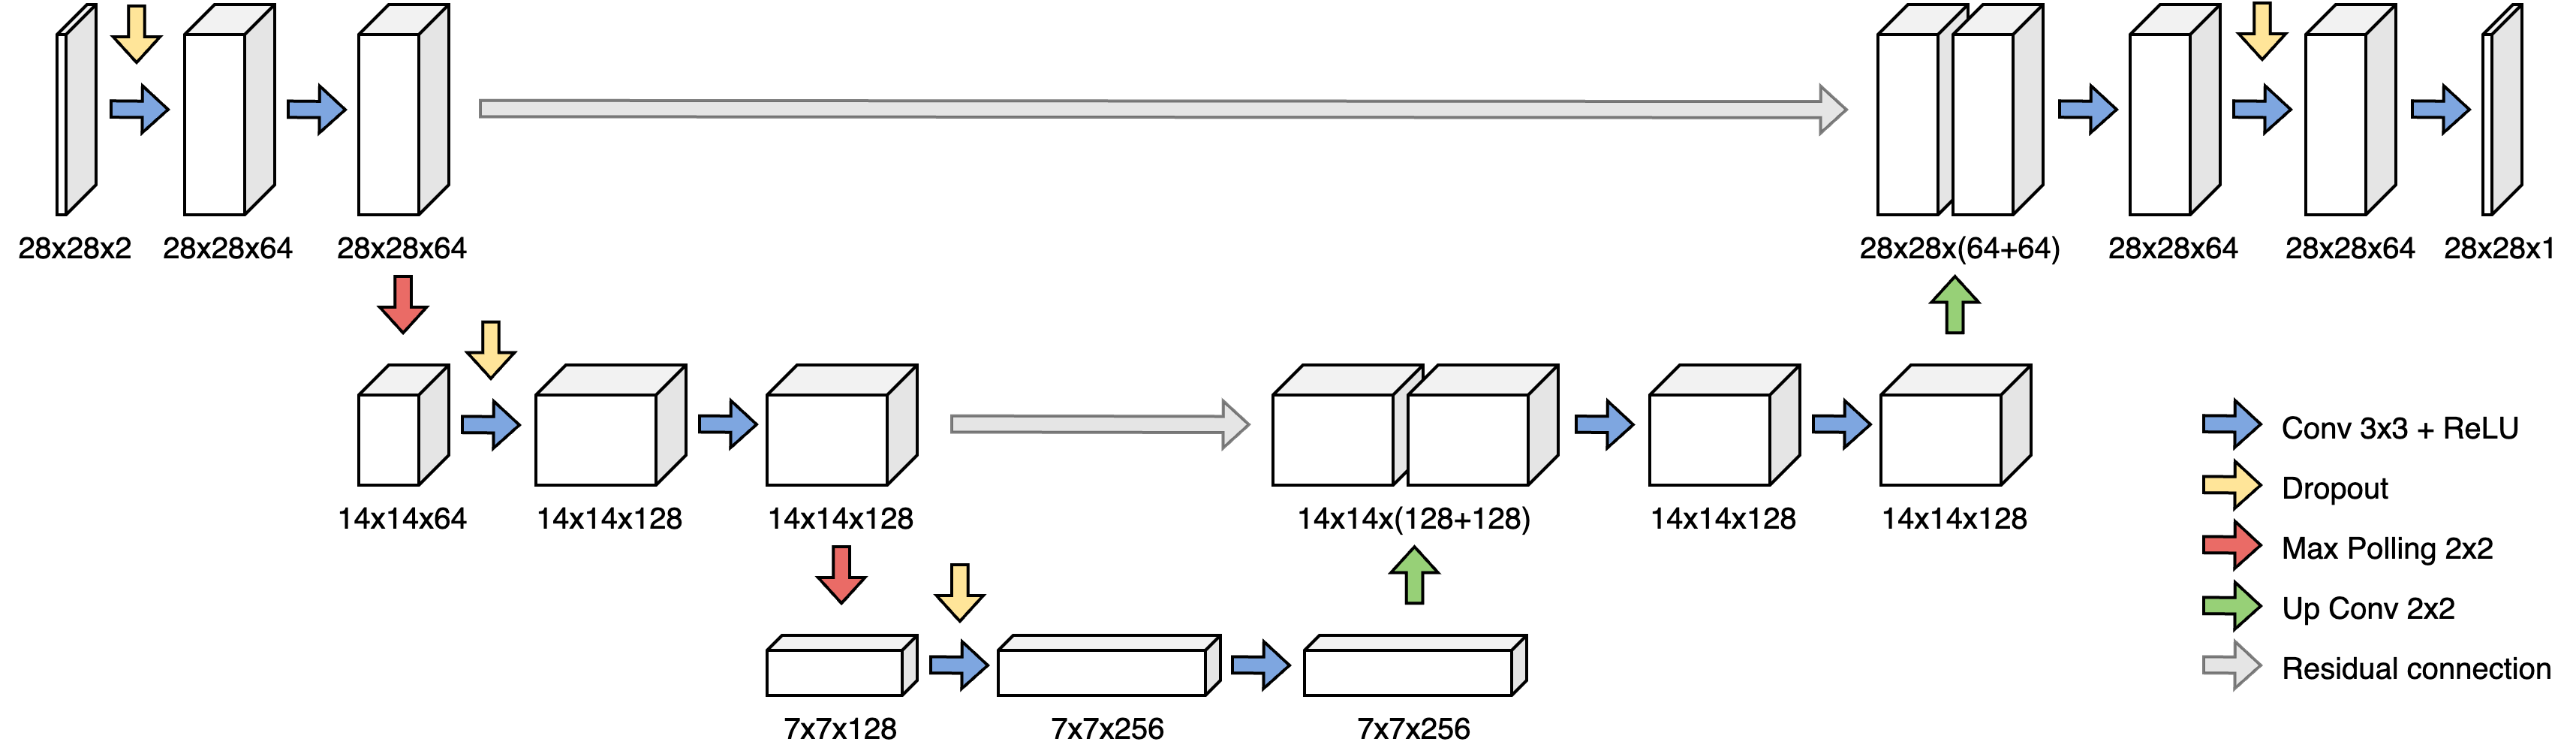

In [319]:
C = 128

class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float=0.3):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        # Encoder
        # input: 28x28xIN
        self.e11 = nn.Conv2d(in_channels, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpe11 = nn.Dropout(p=dropout)
        self.e12 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpe12 = nn.Dropout(p=dropout)
        self.e13 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 14x14xC//2

        # input: 14x14xC//2
        self.e21 = nn.Conv2d(C//2, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpe21 = nn.Dropout(p=dropout)
        self.e22 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpe22 = nn.Dropout(p=dropout)
        self.e23 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 28x28xC
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 7x7xC

        # input: 7x7xC
        self.e31 = nn.Conv2d(C, 2*C, kernel_size=3, padding=1) # output: 7x7x2*C
        self.dpe31 = nn.Dropout(p=dropout)
        self.e32 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1) # output: 7x7x2*C
        self.dpe32 = nn.Dropout(p=dropout)
        self.e33 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1) # output: 7x7xC

        # Decoder
        # input: 7x7x2*C
        self.upconv1 = nn.ConvTranspose2d(2*C, C, kernel_size=2, stride=2) # output: 14x14xC
        self.d11 = nn.Conv2d(2*C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpd11 = nn.Dropout(p=dropout)
        self.d12 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpd12 = nn.Dropout(p=dropout)
        self.d13 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC

        # input: 14x14x2*C
        self.upconv2 = nn.ConvTranspose2d(C, C//2, kernel_size=2, stride=2) # output: 28x28x7
        self.d21 = nn.Conv2d(C, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpd21 = nn.Dropout(p=dropout)
        self.d22 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpd22 = nn.Dropout(p=dropout)
        self.d23 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2

        # Output layer
        # input: 28x28xC//2
        self.outconv = nn.Conv2d(C//2, out_channels, kernel_size=1) # output: 28x28xOUT

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass on the model.

        Args:
            x (torch.Tensor): input data.

        Returns:
            torch.Tensor: output data.
        """
        # Encode the input data
        xe11 = self.dpe11(relu(self.e11(x)))
        xe12 = self.dpe12(relu(self.e12(xe11)))
        xe13 = relu(self.e13(xe12))
        xp1 = self.pool1(xe11)

        xe21 = self.dpe21(relu(self.e21(xp1)))
        xe22 = self.dpe22(relu(self.e22(xe21)))
        xe23 = relu(self.e23(xe22))
        xp2 = self.pool2(xe23)

        xe31 = self.dpe31(relu(self.e31(xp2)))
        xe32 = self.dpe32(relu(self.e32(xe31)))
        xe33 = relu(self.e33(xe32))

        # Decode the computed encoding
        xu11 = self.upconv1(xe33)
        xu12 = torch.cat([xu11, xe23], dim=1)
        xd11 = self.dpd11(relu(self.d11(xu12)))
        xd12 = self.dpd12(relu(self.d12(xd11)))
        xd13 = relu(self.d13(xd12))

        xu21 = self.upconv2(xd13)
        xu22 = torch.cat([xu21, xe13], dim=1)
        xd21 = self.dpd21(relu(self.d21(xu22)))
        xd22 = self.dpd22(relu(self.d22(xd21)))
        xd23 = relu(self.d23(xd22))

        # Output layer
        out = self.outconv(xd23)
        return out
class Encoder(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, latent_dim: int = 32, dropout: float=0.3):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        C = self.out_channels  


        self.e11 = nn.Conv2d(in_channels, C//2, kernel_size=3, padding=1)  # 28x28xC//2
        self.dpe11 = nn.Dropout(p=dropout)
        self.e12 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1)  # 28x28xC//2
        self.dpe12 = nn.Dropout(p=dropout)
        self.e13 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1)  # 28x28xC//2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14xC//2

        
        self.e21 = nn.Conv2d(C//2, C, kernel_size=3, padding=1)  # 14x14xC
        self.dpe21 = nn.Dropout(p=dropout)
        self.e22 = nn.Conv2d(C, C, kernel_size=3, padding=1)  # 14x14xC
        self.dpe22 = nn.Dropout(p=dropout)
        self.e23 = nn.Conv2d(C, C, kernel_size=3, padding=1)  # 14x14xC
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 7x7xC

        
        self.e31 = nn.Conv2d(C, 2*C, kernel_size=3, padding=1)  # 7x7x2C
        self.dpe31 = nn.Dropout(p=dropout)
        self.e32 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1)  # 7x7x2C
        self.dpe32 = nn.Dropout(p=dropout)
        self.e33 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1)  # 7x7x2C

        
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(7*7*2*C, latent_dim)      
        self.fc_logvar = nn.Linear(7*7*2*C, latent_dim)  

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:

        std = torch.exp(0.5 * logvar)  
        eps = torch.randn_like(std)    
        z = mu + eps * std             
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        xe11 = self.dpe11(F.relu(self.e11(x)))
        xe12 = self.dpe12(F.relu(self.e12(xe11)))
        xe13 = F.relu(self.e13(xe12))
        xp1 = self.pool1(xe13)

        xe21 = self.dpe21(F.relu(self.e21(xp1)))
        xe22 = self.dpe22(F.relu(self.e22(xe21)))
        xe23 = F.relu(self.e23(xe22))
        xp2 = self.pool2(xe23)

        xe31 = self.dpe31(F.relu(self.e31(xp2)))
        xe32 = self.dpe32(F.relu(self.e32(xe31)))
        xe33 = F.relu(self.e33(xe32))


        xf = self.flatten(xe33)


        mu = self.fc_mu(xf)
        logvar = self.fc_logvar(xf)


        z = self.reparameterize(mu, logvar)

        return z, mu, logvar


## Bayesian Flow Network
Then we define the BFN model, adapted for 2D data.

### Model definition

In [320]:
model = Encoder(in_channels=1, out_channels=64, latent_dim=32)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
           Dropout-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
           Dropout-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]          18,496
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          36,928
          Dropout-10           [-1, 64, 14, 14]               0
           Conv2d-11           [-1, 64, 14, 14]          36,928
        MaxPool2d-12             [-1, 64, 7, 7]               0
           Conv2d-13            [-1, 128, 7, 7]          73,856
          Dropout-14            [-1, 12

In [345]:
class BayesianFlowNetwork2D(nn.Module):
    def __init__(self, network, encoder, D, K, beta=3.0):
        super(BayesianFlowNetwork2D, self).__init__()
        self.beta = beta
        self.D = D
        self.K = K
        self.network = network
        self.encoder = encoder
        self.ada = nn.Linear(32,28*28*2)
        

    def forward(self, theta: torch.Tensor, t: torch.Tensor,zz, ema: torch_ema.ExponentialMovingAverage) -> torch.Tensor:
        """
        Performs a forward pass.

        Args:
            theta (torch.Tensor)
            t (torch.Tensor): time factor
            ema (torch_ema.ExponentialMovingAverage): EMA used in the model.

        Returns:
            torch.Tensor
        """
        theta = (theta * 2) - 1  # scaled in [-1, 1]
        theta = torch.transpose(theta, 1, 3)
        #print(zz.shape)
        zz = torch.transpose(zz.reshape(theta.shape[0],28,28,2), 1, 3)
        # print(theta.shape)
        
        # assert False
        if ema is not None:
          with ema.average_parameters():
            output = self.network(theta + t[:, None, None, None]+zz)  # (B, D, D, K)
        else:
          output = self.network(theta + t[:, None, None, None]+zz)  # (B, D, D, K)
        return torch.transpose(output, 1, 3)

    def discrete_output_distribution(self, theta: torch.Tensor, t: torch.Tensor,zz,ema: torch_ema.ExponentialMovingAverage=None) -> torch.Tensor:
        """
        Computes the discrete output distribution of the model.

        Args:
            theta (torch.Tensor)
            t (torch.Tensor): time factor
            ema (torch_ema.ExponentialMovingAverage, optional): EMA used in the model. Defaults to None.

        Returns:
            torch.Tensor
        """
        # Forward pass
        output = self.forward(theta, t, zz,ema=ema)
        # Compute the output probabilities accordingly
        if self.K == 2:
            p0_1 = torch.sigmoid(output)  # (B, D, D, 1)
            p0_2 = 1 - p0_1
            p0 = torch.cat((p0_1, p0_2), dim=-1)  # (B, D, D, 2)
        else:
            p0 = torch.nn.functional.softmax(output, dim=-1)
        return p0

    def process(self, x: torch.Tensor, time: float=None, training: bool=True):
        """
        Performs a step of the process.

        Args:
            x (torch.Tensor): input data.
            time (float, optional): time factor in the process. In [0, 1]. Defaults to None.
            training (bool, optional): weither it is during training phase or not. Defaults to True.

        Returns:
            torch.Tensor | tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: if training, only returns the current loss. Otherwise, returns the loss, the generated images, the categorical images and the time factor
        """
        #pre
        
        # Step 1: Sample t from U(0, 1) if not provided
        t = torch.tensor(time, device=x.device, dtype=torch.float32)[None] if time else torch.rand((x.size(0),), device=x.device, dtype=torch.float32)
        # Step 2: Calculate Beta
        beta = self.beta * (t ** 2)  # (B,)
        # Step 3: Sample y from N(beta * (K * one_hot(X))
        one_hot_x = F.one_hot(x.permute(0, 2, 3, 1).to(torch.int64), num_classes=self.K).float().squeeze()  # (B, D, D, K)
        mean = beta[:, None, None, None] * (self.K * one_hot_x - 1)
        std = (beta * self.K)[:, None, None, None].sqrt()
        eps = torch.randn_like(mean)
        y = mean + std * eps
        # Step 4: Compute the Theta
        theta = F.softmax(y, dim=-1)
        # Step 5: Calculate the output distribution
        #print(theta.shape)
        z,mu, log_var= self.encoder(theta.permute(0,3,1,2))
        kld_loss = torch.sum(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)
        # print("z:",z.shape)
        zz = self.ada(z)
        # print("zz:",zz.shape)
        p_0 = self.discrete_output_distribution(theta,  t, zz)  # (B, D, D, K)
        
        e_x = one_hot_x
        e_hat = p_0  # (B, D, D, K)
        L_infinity = self.K * self.beta * t[:, None, None, None] * ((e_x - e_hat) ** 2)
        print("loss:",L_infinity.mean().item())
        print("KL:",kld_loss.mean())
        if training:
          return L_infinity.mean()+kld_loss.mean()
        else:
           k = torch.distributions.Categorical(probs=p_0).sample()
           return L_infinity.mean(), y, k, t

    @torch.inference_mode()
    def sample(self, batch_size: int=128, nb_steps: int=10, ema: torch_ema.ExponentialMovingAverage=None, device: str='cpu') -> torch.Tensor:
        self.eval()
        # get prior
        theta = torch.ones((batch_size, self.D, self.D, self.K), device=device) / self.K
        t = torch.zeros((theta.shape[0]), device=theta.device, dtype=theta.dtype)
        z = torch.randn(theta.shape[0],32).cuda()
        # print("z:",z.shape)
        zz = self.ada(z)
        for i in tqdm(range(1, nb_steps+1)):
            t = (i-1) / nb_steps
            t = t * torch.ones((theta.shape[0]), device=theta.device, dtype=theta.dtype)
            k_probs = self.discrete_output_distribution(theta, t, zz,ema=ema)  # (B, D, D, K)
            k = torch.distributions.Categorical(probs=k_probs).sample()  # (B, D, D)
            alpha = self.beta * (2 * i - 1) / (nb_steps ** 2)
            e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, D, K)
            mean = alpha * (self.K * e_k - 1)
            var = (alpha * self.K)
            std = torch.full_like(mean, fill_value=var).sqrt()
            eps = torch.randn_like(e_k)
            y = mean + std * eps  # (B, D, D, K)
            theta_prime = torch.exp(y) * theta
            theta = theta_prime / theta_prime.sum(-1, keepdim=True)
        k_probs_final = self.discrete_output_distribution(theta, torch.ones_like(t),zz,ema=ema)
        k_final = torch.distributions.Categorical(probs=k_probs_final).sample()
        return k_final

In [346]:
unet = UNet(2, 1, dropout=0.5)
encoder = Encoder(in_channels=2, out_channels=64, latent_dim=32)
bfn = BayesianFlowNetwork2D(network=unet,encoder=encoder, D=28, K=2).to(DEVICE)
ema = torch_ema.ExponentialMovingAverage(bfn.network.parameters(), decay=0.9999)
ema.to(DEVICE)

### Model training
The following cell exposes useful parameters for the training process. <br>
Here is a small breakdown of the role played by each of these parameters:
- `EPOCHS`: maximum number of epochs for the training process. Depending on the patience value, the training process might stop earlier.
- `EARLY_STOPPING`: weither to stop after a single epoch or not.
- `PATIENCE`: number of training steps after which the training process is stopped if the loss function has not been improved.
- `LEARNING_RATE`: learning rate used for optimizing the network.

If you want a quicker training process, choose lower values. If you need better results, choose higher parameters.

In [365]:
EPOCHS = 100
EARLY_STOPPING = False
PATIENCE = 1e6
LEARNING_RATE = 3e-4

We can then train the BFN on the data we previously prepared.

In [366]:
optim = AdamW(bfn.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), weight_decay=0.01)

In [367]:
def train_model(model: BayesianFlowNetwork2D, optimizer: torch.optim.Optimizer) -> list[float]:
  """
  Train a BFN model, given an optimizer.

  Args:
      model (BayesianFlowNetwork2D)
      optimizer (torch.optim.Optimizer)

  Returns:
      list[float]: training losses.
  """
  bfn_path = MODELS_PATH + "mnist_bfn.pt"
  if SAVE_MODEL:
    if os.path.exists(bfn_path):
      checkpoint = torch.load(bfn_path)
      model.load_state_dict(checkpoint['model_state_dict'])
      print(f"Trained model found, training process skipped. To train a new model, remove the file {bfn_path}.")
      return checkpoint["training_losses"]
  losses = []
  best_loss = inf
  k = 0
  stop = EARLY_STOPPING
  i = 0
  for i in range(EPOCHS):
    for X, _ in tqdm(train_loader, desc=f"Epoch {i+1}/{EPOCHS}"):
        optimizer.zero_grad()
        loss = model.process(X.to(DEVICE))
        loss.backward()
        optimizer.step()
        ema.update()
        losses.append(loss.item())
        if loss.item() < best_loss:
          best_loss = loss.item()
          k = 0
        else:
          k += 1
          if k == PATIENCE:
            k = 0
            stop = True
            print("Patience value has been reached, ending training process.")
            break
    if stop:
      break
  print(f"Model trained in {i+1} epochs.")
  if SAVE_MODEL:
    torch.save({"model_state_dict": model.state_dict(), "training_losses": losses}, bfn_path)
    print(f"Trained model saved at {bfn_path}")
  return losses

In [368]:
import torch
import os

# Disable deterministic algorithms
torch.use_deterministic_algorithms(False)

# Alternatively, control cuDNN deterministic behavior
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
training_losses = train_model(bfn, optim)

Epoch 1/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.04292910173535347
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.10392985492944717
KL: tensor(0.0211, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.05771046131849289
KL: tensor(0.0023, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.049491554498672485
KL: tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.059917379170656204
KL: tensor(0.0083, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.059726160019636154
KL: tensor(0.0033, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.052809517830610275
KL: tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.04904596880078316
KL: tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.04864683002233505
KL: tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.04524438455700874
KL: tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.04919873923063278
KL: tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.04805072396993637
KL: tensor(0.

Epoch 2/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03930707648396492
KL: tensor(1.0878e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.040327876806259155
KL: tensor(-1.0192e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0397852323949337
KL: tensor(-1.1265e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.041406188160181046
KL: tensor(4.7058e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03984254226088524
KL: tensor(4.3392e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.039075709879398346
KL: tensor(2.4140e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03911430761218071
KL: tensor(2.2352e-06, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.041335757821798325
KL: tensor(2.2948e-06, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03995824605226517
KL: tensor(1.7613e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.04052237048745155
KL: tensor(5.3048e-06, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03926577791571617
KL: tensor(2.3484e-05, device='cuda:0', grad_fn=<MeanBackwa

Epoch 3/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.040868211537599564
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03940199315547943
KL: tensor(9.2655e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03824468329548836
KL: tensor(8.8304e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03904607892036438
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03900543600320816
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03868429362773895
KL: tensor(8.6904e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.040001511573791504
KL: tensor(4.0710e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.04042401537299156
KL: tensor(7.5668e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.039890289306640625
KL: tensor(7.9721e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0401667021214962
KL: tensor(7.6532e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0396701879799366
KL: tensor(5.3674e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03

Epoch 4/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03882334753870964
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03782932460308075
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.037336912006139755
KL: tensor(8.9079e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0372081883251667
KL: tensor(7.8976e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.038919366896152496
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03849009424448013
KL: tensor(8.2850e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.039875563234090805
KL: tensor(9.8705e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03826877102255821
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03766953572630882
KL: tensor(8.7887e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03979567438364029
KL: tensor(9.3043e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.040343526750802994
KL: tensor(7.8887e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0376

Epoch 5/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.038074348121881485
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.037721943110227585
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03723343089222908
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03839970380067825
KL: tensor(6.7383e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.038271550089120865
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03794609382748604
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03740634769201279
KL: tensor(9.0510e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03777364268898964
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03997821733355522
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.037076447159051895
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03781091421842575
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.037207942456007004
KL: 

Epoch 6/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03923507407307625
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03857347369194031
KL: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03910677134990692
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.038494888693094254
KL: tensor(9.9212e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03903758153319359
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03833362087607384
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03965918347239494
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03789320960640907
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03878673166036606
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03770899027585983
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03882350027561188
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03884202241897583
KL: tensor(0

Epoch 7/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03763902187347412
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0373455211520195
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03843827173113823
KL: tensor(9.4295e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03648117929697037
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03764085844159126
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.038469523191452026
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.038021817803382874
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.037375688552856445
KL: tensor(7.7963e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03604120388627052
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03824916481971741
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03704873099923134
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03841029107570648
KL: ten

Epoch 8/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03790303319692612
KL: tensor(7.7426e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03628125786781311
KL: tensor(8.1033e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03773069754242897
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03746960312128067
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03745140880346298
KL: tensor(9.0182e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03661729395389557
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03773479536175728
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036160364747047424
KL: tensor(8.8185e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03707375377416611
KL: tensor(8.4788e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03658709675073624
KL: tensor(8.3506e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03554748743772507
KL: tensor(9.8497e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035726

Epoch 9/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.036231476813554764
KL: tensor(8.8960e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03682173043489456
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.038200799375772476
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0359976589679718
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036552585661411285
KL: tensor(9.5606e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03574409335851669
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035245925188064575
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.037097278982400894
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03650821000337601
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03722970187664032
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03711966797709465
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03639732673764229
KL: t

Epoch 10/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03758155554533005
KL: tensor(8.6188e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03525257855653763
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03670525923371315
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03709251061081886
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03852783516049385
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03769993036985397
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03714153543114662
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0362606905400753
KL: tensor(9.8944e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03686540573835373
KL: tensor(9.5576e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034245364367961884
KL: tensor(9.5665e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.038525570183992386
KL: tensor(7.9751e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03589505329728

Epoch 11/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03647885471582413
KL: tensor(8.1867e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.039699435234069824
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03725401684641838
KL: tensor(7.5132e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03786913678050041
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03752966225147247
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03796905651688576
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03471864014863968
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036375001072883606
KL: tensor(8.5115e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03537823259830475
KL: tensor(9.9361e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03695549815893173
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036287736147642136
KL: tensor(9.2685e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036383971571

Epoch 12/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03558066114783287
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03768511489033699
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03566364198923111
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03655293583869934
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03664933145046234
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036203134804964066
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035560932010412216
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03656613826751709
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036136481910943985
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03550966456532478
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0357145331799984
KL: tensor(8.6337e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0357428714632988
KL: tensor(0

Epoch 13/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03505625203251839
KL: tensor(9.6738e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036394983530044556
KL: tensor(9.3162e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03492239862680435
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03701396659016609
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03475499898195267
KL: tensor(7.8499e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035665299743413925
KL: tensor(8.9943e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03616192191839218
KL: tensor(9.8675e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036981452256441116
KL: tensor(9.6202e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035283662378787994
KL: tensor(7.4893e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035308655351400375
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03756493702530861
KL: tensor(7.4595e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 

Epoch 14/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.037084564566612244
KL: tensor(9.9272e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03622668609023094
KL: tensor(8.8602e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035657767206430435
KL: tensor(7.8976e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03657026216387749
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03501329943537712
KL: tensor(8.7291e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03615964576601982
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03670039400458336
KL: tensor(8.4370e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03568417951464653
KL: tensor(7.2122e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0371200293302536
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034515898674726486
KL: tensor(5.9932e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03518403694033623
KL: tensor(7.2718e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0

Epoch 15/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03642943874001503
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035587262362241745
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034698426723480225
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03466550633311272
KL: tensor(9.1285e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035277556627988815
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03666730597615242
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03482342138886452
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03621744364500046
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.037286169826984406
KL: tensor(8.5831e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035124022513628006
KL: tensor(8.9377e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03540502116084099
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03678987920284271


Epoch 16/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.0361509695649147
KL: tensor(8.9139e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03554325923323631
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03510387986898422
KL: tensor(8.8841e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036528926342725754
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03644951805472374
KL: tensor(9.2775e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035150375217199326
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033982470631599426
KL: tensor(9.2536e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03456095606088638
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03467085212469101
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03649020567536354
KL: tensor(8.8871e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036985840648412704
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035685028880

Epoch 17/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03605300560593605
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03535482659935951
KL: tensor(5.8770e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035054754465818405
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03414803743362427
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03673084080219269
KL: tensor(3.1739e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03569827601313591
KL: tensor(9.4146e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036133140325546265
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03566354140639305
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03573496267199516
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035704221576452255
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033994048833847046
KL: tensor(6.7949e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036895267665386

Epoch 18/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.034575819969177246
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03625163808465004
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03450740873813629
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035342276096343994
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03552435711026192
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03655056282877922
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03642284497618675
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035657498985528946
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035695429891347885
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03596954047679901
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03589677810668945
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03649229928

Epoch 19/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.0359325110912323
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03496309369802475
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03550315648317337
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03459930792450905
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03558197617530823
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036299243569374084
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03475506603717804
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0352175310254097
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03540533781051636
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03504710644483566
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03593864291906357
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03538793325424194
KL: tensor

Epoch 20/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.033663149923086166
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03415016084909439
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03502705693244934
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03478614240884781
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03572501987218857
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03493041917681694
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034853745251894
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03529423847794533
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03448477387428284
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035983607172966
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0353405587375164
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03607058525085449
KL: t

Epoch 21/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03386035934090614
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03652893751859665
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03486683592200279
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036157891154289246
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0349450558423996
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0345759280025959
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03408017382025719
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03603275492787361
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03488605096936226
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03423939645290375
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03550997003912926
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0336259

Epoch 22/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.036060210317373276
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034675177186727524
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.036215782165527344
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03587440028786659
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03380325809121132
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03606404364109039
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033566221594810486
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03391299024224281
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03588831424713135
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035529620945453644
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033818840980529785
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
l

Epoch 23/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.0338294692337513
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035582009702920914
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0355011448264122
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03408440575003624
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03521795943379402
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034508347511291504
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03434070944786072
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03369230031967163
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033264875411987305
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03456295281648636
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03589281439781189
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03443782776594162
KL: 

Epoch 24/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.033287886530160904
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03367280587553978
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034518469125032425
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03286978229880333
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03395208716392517
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03456311300396919
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03491899371147156
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034054454416036606
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03382198512554169
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03390013799071312
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034717973321676254
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03422904387

Epoch 25/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.034213706851005554
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03431762754917145
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03277391567826271
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03364882245659828
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033253263682127
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032588209956884384
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03413732722401619
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03374376893043518
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03326896205544472
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0355827696621418
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03427276387810707
KL: tensor(-0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03515889495

Epoch 26/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.0350525937974453
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03369937092065811
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03594958037137985
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03479263186454773
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0341181717813015
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033986836671829224
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03546919673681259
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03463852405548096
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033700838685035706
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03369634598493576
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03400128334760666
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033014219254255

Epoch 27/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03315286338329315
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03420931473374367
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034269124269485474
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035038694739341736
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032693590968847275
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03571445494890213
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033956512808799744
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03350874409079552
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03327960520982742
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03452466428279877
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032846998423337936
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034235548228025436
KL

Epoch 28/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03426118567585945
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03330620005726814
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03599004074931145
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03462785482406616
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033238157629966736
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033571891486644745
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03547506406903267
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0330289863049984
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03465466946363449
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03378332406282425
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03314151614904404
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0335

Epoch 29/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03360414132475853
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033110011368989944
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032406751066446304
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03397851437330246
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033789314329624176
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03438439592719078
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03414824604988098
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03451710194349289
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033737894147634506
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03397762030363083
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03343788534402847
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03322014585137

Epoch 30/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03374679014086723
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033718399703502655
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03371218591928482
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03426559641957283
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03300416097044945
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03469116985797882
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03354931250214577
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03446032106876373
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03357315808534622
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0320599265396595
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0336451455950737
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss

Epoch 31/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03397434949874878
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03368082642555237
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034341149032115936
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03349512070417404
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03308699652552605
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03348126262426376
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03322220593690872
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03394708037376404
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03205055370926857
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034961238503456116
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03398975357413292
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0344201885163

Epoch 32/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03309400752186775
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032766394317150116
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033392202109098434
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032632652670145035
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0332438200712204
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033507656306028366
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033738818019628525
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03241637349128723
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034551337361335754
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03286318853497505
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03292802348732948
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031832

Epoch 33/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.033494651317596436
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0353323370218277
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033536337316036224
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03321467339992523
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034966688603162766
KL: tensor(-7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03208213672041893
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03424344211816788
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03248116746544838
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03409301117062569
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033127833157777786
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0348469577729702
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034155610948

Epoch 34/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03443301469087601
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03468853607773781
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0345119945704937
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03351921960711479
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03232482820749283
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03406571224331856
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03288411721587181
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03336912393569946
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03266235813498497
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034251969307661057
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034657128155231476
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0332914739

Epoch 35/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03250829875469208
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0322459451854229
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03271814063191414
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033706869930028915
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032449472695589066
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03390401974320412
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034918949007987976
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034710802137851715
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033977895975112915
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03282451629638672
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03385132551193237
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0342343412339

Epoch 36/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03436678647994995
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03443127125501633
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03244085982441902
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033989887684583664
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034712255001068115
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033724069595336914
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03470083698630333
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033770520240068436
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032525792717933655
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03422648087143898
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033772703260183334
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03333621844649315
KL: ten

Epoch 37/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03205539658665657
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03438204154372215
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03466813266277313
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0341392420232296
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03340575471520424
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03436663746833801
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03219906985759735
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034549906849861145
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032727207988500595
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03305714949965477
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03557175397872925
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0346711464226

Epoch 38/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03377130627632141
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03413103520870209
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03227147087454796
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03540622070431709
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032262738794088364
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032991666346788406
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03299446031451225
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03380226716399193
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03207945451140404
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03243553265929222
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030875667929649353
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0335904918611049

Epoch 39/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03398383781313896
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032421261072158813
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03271832317113876
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03226667270064354
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03229520842432976
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03346491605043411
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033531226217746735
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03337572142481804
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03474834933876991
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033556193113327026
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03288423642516136
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0325908921658992

Epoch 40/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03366129845380783
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03327598795294762
KL: tensor(-0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032407063990831375
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033520013093948364
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03262930363416672
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03333178535103798
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03360028564929962
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03345225378870964
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034758687019348145
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032594189047813416
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03545001894235611
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033966

Epoch 41/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03232905641198158
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03159961849451065
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03477029502391815
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03153661638498306
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033246736973524094
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0336124561727047
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03347019851207733
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03275405988097191
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031934741884469986
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03243549168109894
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03353765606880188
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03377151116728783
KL: tensor(6.103

Epoch 42/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03207559138536453
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031285595148801804
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032916076481342316
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033200252801179886
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03234359249472618
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0333939790725708
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033178478479385376
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03271559253334999
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03406349569559097
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0335836261510849
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03308534622192383
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0317657

Epoch 43/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03274296596646309
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03296416252851486
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03269519284367561
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032852936536073685
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0332026332616806
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033015426248311996
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.035399552434682846
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03279919549822807
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03420453518629074
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03277629241347313
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033493753522634506
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0

Epoch 44/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03413871303200722
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03259888291358948
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03310040757060051
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03405868634581566
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03248724713921547
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030747950077056885
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03199402242898941
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032597459852695465
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0330742672085762
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03223302960395813
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03138807415962219
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03537190705537796
KL: 

Epoch 45/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03113405965268612
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03355690464377403
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03385331854224205
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03177647292613983
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03379497677087784
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032302748411893845
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03393487632274628
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03361263871192932
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032289352267980576
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03233526647090912
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03270009160041809
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0321754552423954

Epoch 46/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.034081194549798965
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033079732209444046
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0332673080265522
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03168344870209694
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03342205658555031
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031686022877693176
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032809413969516754
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032106913626194
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03295782208442688
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03226853907108307
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03352649137377739
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03206

Epoch 47/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03129567950963974
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03134387731552124
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030976980924606323
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033800456672906876
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03191932290792465
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03289477527141571
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033300142735242844
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033199526369571686
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03255921229720116
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03405216336250305
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033951133489608765
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03384

Epoch 48/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.033075347542762756
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03233031928539276
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0331367664039135
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03362700343132019
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03313232213258743
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03120936080813408
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032147366553545
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03205707669258118
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03287868946790695
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03374668210744858
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03400518745183945
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033919982

Epoch 49/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03190981596708298
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03139795362949371
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03294782713055611
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034719306975603104
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03191940486431122
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032039426267147064
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03217332065105438
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031342461705207825
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03291705623269081
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03193064406514168
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032459862530231476
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03218122571706

Epoch 50/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.032262224704027176
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03181780129671097
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03152250126004219
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03378758206963539
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032659370452165604
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03375255689024925
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031748831272125244
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03224873170256615
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031282443553209305
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031627655029296875
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03308940306305885
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032943

Epoch 51/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03355319797992706
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03324948623776436
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03348535671830177
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032692935317754745
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0342462919652462
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0335950069129467
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032594095915555954
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03259817510843277
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03198367729783058
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03141389042139053
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03200851008296013
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0327945

Epoch 52/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03291958197951317
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033147405833005905
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03302492946386337
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03261931613087654
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03183808922767639
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032389719039201736
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03292574733495712
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031243877485394478
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03372928127646446
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03186269477009773
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03150276839733124
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
los

Epoch 53/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03313227370381355
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0320255421102047
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0317363440990448
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033074770122766495
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03253853693604469
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03321273997426033
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03302687779068947
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031161444261670113
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034131716936826706
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033052656799554825
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03217829763889313
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03221

Epoch 54/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03199275955557823
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03238629177212715
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031370311975479126
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033356718719005585
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03207774460315704
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033068690448999405
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031015438959002495
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03386484459042549
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03238460421562195
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03321155533194542
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033460427075624466
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 

Epoch 55/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03138053044676781
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03263187035918236
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031977880746126175
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032764092087745667
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032520681619644165
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031003469601273537
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03021126799285412
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032234419137239456
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031770117580890656
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0329815037548542
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0323532298207283
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0

Epoch 56/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.032796118408441544
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033406659960746765
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033068425953388214
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03280312195420265
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03192955628037453
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03085854835808277
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03268095850944519
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03257216513156891
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03288576006889343
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03262096270918846
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03280233219265938
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0339254

Epoch 57/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03226880729198456
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03141549602150917
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03262576088309288
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03219345957040787
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031969960778951645
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03335099294781685
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03242463991045952
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0329112708568573
KL: tensor(-6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03320503607392311
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03271720930933952
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03236301988363266
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03

Epoch 58/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.032343678176403046
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03303622081875801
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0321333147585392
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033380672335624695
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03168759122490883
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03450949117541313
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03251667320728302
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03164904564619064
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032048340886831284
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03194904327392578
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03352799266576767
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0

Epoch 59/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03163702413439751
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03330915793776512
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03292713686823845
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03199917823076248
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03175514563918114
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03229982778429985
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03102107159793377
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031953174620866776
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031553640961647034
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03295605629682541
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03165701776742935
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03232659399

Epoch 60/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03394171595573425
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032783716917037964
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031163137406110764
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032193128019571304
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031737811863422394
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0318804606795311
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03179474174976349
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031519386917352676
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03240343555808067
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03330500051379204
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0326753593981266
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0317240245640277

Epoch 61/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03378580883145332
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031331758946180344
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03290287405252457
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033537521958351135
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03186246380209923
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03283894062042236
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03369460627436638
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03392293304204941
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03184153512120247
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03200233727693558
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03339244797825813
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0320709869265556

Epoch 62/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03356962278485298
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032216887921094894
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03366745635867119
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03173200041055679
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03304954990744591
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033103298395872116
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03154037520289421
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03104533813893795
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03334479033946991
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033396728336811066
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03185252845287323
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0331026129424572
KL: tensor(

Epoch 63/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03351014107465744
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032976921647787094
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032585710287094116
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03136038780212402
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032046396285295486
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03147586062550545
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03160344436764717
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032703276723623276
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03202823922038078
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032079003751277924
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03154841065406799
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0

Epoch 64/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.031350117176771164
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033155255019664764
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03271759673953056
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031333573162555695
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03259913623332977
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03224795311689377
KL: tensor(-6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032038576900959015
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03225495666265488
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032959140837192535
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03330639749765396
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03331710398197174
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031922928

Epoch 65/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.032266806811094284
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03311172127723694
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032721541821956635
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031233742833137512
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03206169605255127
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03290100395679474
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03239937126636505
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03271673247218132
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031589146703481674
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03251578286290169
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.029790634289383888
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03174

Epoch 66/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.0311395525932312
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03291160240769386
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03164076432585716
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03259005397558212
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031467992812395096
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03244224190711975
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03234231472015381
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030957240611314774
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03229331970214844
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03316860273480415
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03224978968501091
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03174420818686485
KL:

Epoch 67/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03233729675412178
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03233418986201286
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03025880642235279
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0326099693775177
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031616486608982086
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030650164932012558
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032523319125175476
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031532593071460724
KL: tensor(-6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032503098249435425
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03324895724654198
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032615456730127335
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
los

Epoch 68/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.031939249485731125
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03140971437096596
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03175446018576622
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032146986573934555
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032105617225170135
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03310399875044823
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0328558012843132
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033299628645181656
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033642832189798355
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031706489622592926
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03173046559095383
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0310

Epoch 69/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.031142959371209145
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03280814737081528
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031843144446611404
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031805917620658875
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031596455723047256
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030883539468050003
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032508619129657745
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03160611167550087
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03228112310171127
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033007342368364334
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031560927629470825
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>

Epoch 70/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03273284435272217
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030816325917840004
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031435538083314896
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03215750306844711
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031227577477693558
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030834153294563293
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03073718771338463
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03253095597028732
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03255175054073334
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030659010633826256
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03205351531505585
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03209

Epoch 71/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.033300142735242844
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03260805085301399
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03238117694854736
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031075667589902878
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0312079768627882
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03257010504603386
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033088330179452896
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03207264840602875
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03269479051232338
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03124379552900791
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03252812847495079
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031792368

Epoch 72/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03172566369175911
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0321531817317009
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03253554180264473
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033100247383117676
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03130672872066498
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032572537660598755
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03249230980873108
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03168826550245285
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03317033872008324
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032123103737831116
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03270689770579338
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03272654488682747
KL:

Epoch 73/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03153853118419647
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03184584528207779
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03302900865674019
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032971110194921494
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03365963697433472
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0315198116004467
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030742449685931206
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031670354306697845
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03260958567261696
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03236799314618111
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032367464154958725
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0319900

Epoch 74/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03274714574217796
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03161659464240074
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03263554349541664
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03177015855908394
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03176429122686386
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03319791331887245
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032027702778577805
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03137906268239021
KL: tensor(-9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03292927145957947
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03222499042749405
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033175934106111526
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
los

Epoch 75/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.0328054279088974
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03223618119955063
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03294152393937111
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03143272176384926
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03270016238093376
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03208964318037033
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031617630273103714
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03258588910102844
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031971149146556854
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033124424517154694
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03092166781425476
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03402567654

Epoch 76/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.032025910913944244
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03217443823814392
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03086726740002632
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031601808965206146
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031232740730047226
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03203052282333374
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03255647420883179
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03124932385981083
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031800705939531326
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032253436744213104
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03167467564344406
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0305568613

Epoch 77/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03280024230480194
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0309325959533453
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03278002887964249
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03171287104487419
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03175950422883034
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032576367259025574
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032363347709178925
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03141521289944649
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03191955015063286
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032893721014261246
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03361530601978302
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03231501

Epoch 78/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03212282434105873
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03274035081267357
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030887821689248085
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03234507888555527
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03088485077023506
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03223631903529167
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0319165363907814
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.034878965467214584
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030697958543896675
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03254424408078194
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03172185271978378
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.

Epoch 79/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03274926170706749
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031871721148490906
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03289831802248955
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03170191869139671
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031190073117613792
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032803211361169815
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03274095058441162
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0312843844294548
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03236991912126541
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031703487038612366
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0310053788125515
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031753070652

Epoch 80/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03273293748497963
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03209664300084114
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031576063483953476
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03232401981949806
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03359416499733925
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03190654143691063
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03312406316399574
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03273560106754303
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03209977596998215
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030319880694150925
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0326964370906353
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03299427777528763

Epoch 81/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03179186210036278
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03019370511174202
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033466946333646774
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031049668788909912
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032417718321084976
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03300653025507927
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031422942876815796
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031021520495414734
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03196006268262863
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03142954409122467
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032194722443819046
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0318656116724014

Epoch 82/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.0322355255484581
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030140094459056854
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030497627332806587
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031727805733680725
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03142376244068146
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03218717873096466
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032899901270866394
KL: tensor(-7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030497753992676735
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03235187381505966
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03017832338809967
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031103292480111122
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
los

Epoch 83/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03217665106058121
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031511664390563965
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030557502061128616
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03147615119814873
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031125087291002274
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030609577894210815
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030488915741443634
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030261805281043053
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032019127160310745
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03135218471288681
KL: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030546819791197777
KL: tensor(-6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.

Epoch 84/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.0332585871219635
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032302986830472946
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03135614097118378
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03201577067375183
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031648922711610794
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030938852578401566
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03234550729393959
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03308891877532005
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03183705732226372
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030942047014832497
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03038495033979416
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032

Epoch 85/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03145971894264221
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0316217876970768
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0313686840236187
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03158319741487503
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03159605711698532
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03242732584476471
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032278429716825485
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032602932304143906
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031408920884132385
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03247283399105072
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0319373719394207
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033096686005592346
KL:

Epoch 86/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03190726041793823
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03257432207465172
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03093833290040493
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032796718180179596
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03119497559964657
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03202252462506294
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03081795573234558
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03288932517170906
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03180376812815666
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031677164137363434
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030014630407094955
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0334

Epoch 87/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03174060210585594
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031001849099993706
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032157715409994125
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03258173167705536
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03184996172785759
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03172207623720169
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0317961722612381
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032426778227090836
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031221875920891762
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03056846745312214
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03204115107655525
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0319164

Epoch 88/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03091154247522354
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0329330638051033
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0325271338224411
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03135779872536659
KL: tensor(-7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03149206191301346
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03256233409047127
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03322329744696617
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03211945667862892
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03176453709602356
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032461341470479965
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030548637732863426
KL: tensor(-9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0322

Epoch 89/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03204574063420296
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03136000782251358
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03214158117771149
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03254159539937973
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031253017485141754
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03237904608249664
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03140898421406746
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03184979036450386
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03200365602970123
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03315239027142525
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03188064694404602
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031575217843055725
KL:

Epoch 90/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03029642254114151
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.033856406807899475
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03192080929875374
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032046813517808914
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03143466264009476
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03071611188352108
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030985627323389053
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03103519417345524
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03141970559954643
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031219659373164177
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03032231703400612
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0

Epoch 91/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03271491453051567
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03190312907099724
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030507393181324005
KL: tensor(-0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03234012797474861
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03174006566405296
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030055610463023186
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031630851328372955
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031204504892230034
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032568398863077164
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03160640224814415
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.029944175854325294
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
lo

Epoch 92/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.031888823956251144
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03167847543954849
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030400820076465607
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03297167271375656
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03318878635764122
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03171808645129204
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030619295313954353
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03169277310371399
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031334999948740005
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030796842649579048
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03141660615801811
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03344685956835747


Epoch 93/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.031975094228982925
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031087366864085197
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03263136371970177
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030667705461382866
KL: tensor(-4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03183739632368088
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03214460238814354
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030794542282819748
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03238341957330704
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03161754459142685
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03124123066663742
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03184831514954567
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03

Epoch 94/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.032225415110588074
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03275793045759201
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032057810574769974
KL: tensor(-6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03136316314339638
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03201178461313248
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031444430351257324
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03264540061354637
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031031444668769836
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031163394451141357
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03119153343141079
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030749699100852013
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss

Epoch 95/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.031714923679828644
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030798746272921562
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031096721068024635
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03289433941245079
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03152572363615036
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030885346233844757
KL: tensor(-3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03114011324942112
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03141915798187256
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030725998803973198
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030258679762482643
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031759683042764664
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0

Epoch 96/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.031427182257175446
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03121384233236313
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03272339329123497
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032396432012319565
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03014623560011387
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032234810292720795
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03315415978431702
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03209323063492775
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03244730457663536
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0315682552754879
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.02965981513261795
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03066

Epoch 97/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.030414268374443054
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03056398220360279
KL: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03311225399374962
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03135942295193672
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.029971111565828323
KL: tensor(-6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031973399221897125
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031073691323399544
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030490735545754433
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031855758279561996
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032230254262685776
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03159313648939133
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0307831

Epoch 98/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.03309367597103119
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032524242997169495
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030604999512434006
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030894281342625618
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031317438930273056
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031212929636240005
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0319468155503273
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03316107019782066
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031162671744823456
KL: tensor(1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03237295150756836
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03141193091869354
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.0312804207

Epoch 99/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.029461786150932312
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03127950802445412
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031602248549461365
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03182904049754143
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03169398754835129
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03188488632440567
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03132481873035431
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03137876093387604
KL: tensor(3.0518e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03130670264363289
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031962133944034576
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030832698568701744
KL: tensor(7.6294e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031

Epoch 100/100:   0%|          | 0/118 [00:00<?, ?it/s]

loss: 0.030801178887486458
KL: tensor(6.1035e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031988173723220825
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030889036133885384
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.032086845487356186
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031735051423311234
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031704824417829514
KL: tensor(-1.5259e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03141062706708908
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.030395284295082092
KL: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03247705101966858
KL: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03190922364592552
KL: tensor(4.5776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.03211374953389168
KL: tensor(9.1553e-05, device='cuda:0', grad_fn=<MeanBackward0>)
loss: 0.031

Once the model has been trained, we can visualize the loss function evolution during the training process.

Text(0, 0.5, 'Loss')

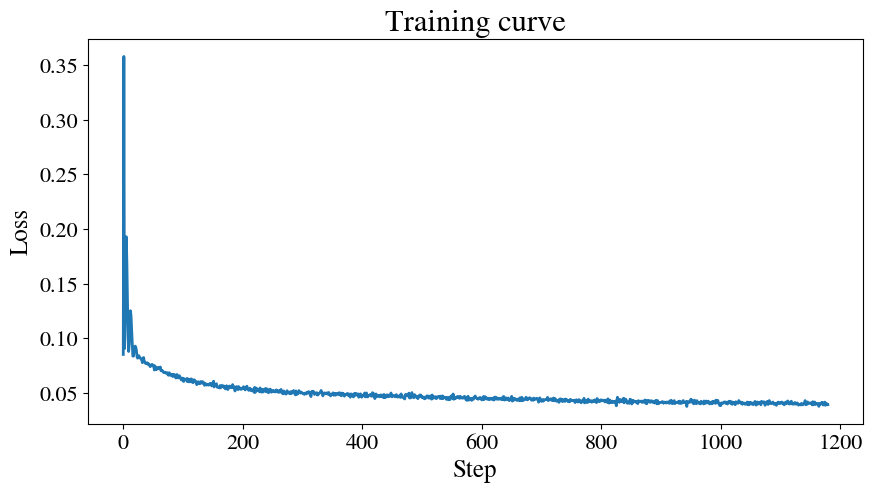

In [360]:
plt.plot(training_losses)
plt.title("Training curve")
plt.xlabel("Step")
plt.ylabel("Loss")
#plt.ylim(0, 0.1);

Text(0, 0.5, 'Loss')

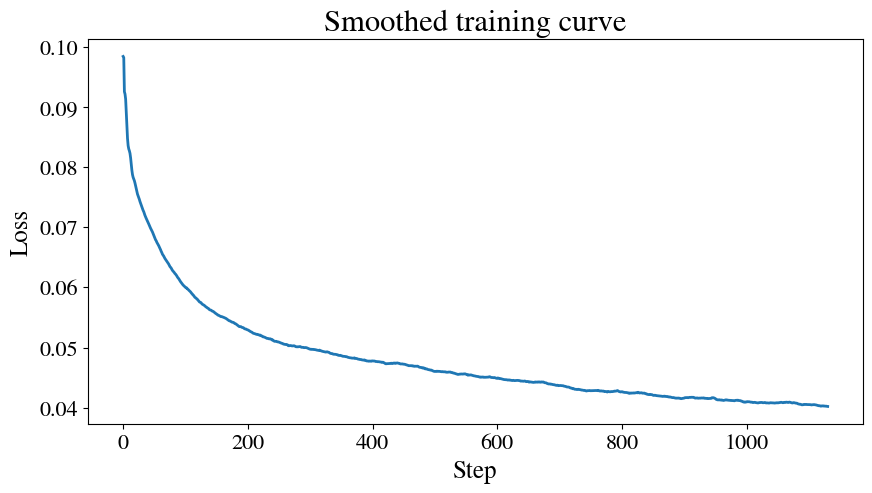

In [361]:
plt.plot(moving_average(training_losses, 50))
plt.title("Smoothed training curve")
plt.xlabel("Step")
plt.ylabel("Loss")
#plt.ylim(0, 0.1);

### Sample generation

Once the model has been trained, we can generate some new images.

In [369]:
x_hat = bfn.sample(device=DEVICE.type, nb_steps=1000, batch_size=16, ema=ema)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [371]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 总共需要生成的图像数量N（10的整数倍）
N = 50000  # 请根据需要修改N的值
batch_size = 10000  # 每次采样的图像数量

save_path = "../CacheDisFID/mnist/Gen/1e4"

import shutil
if os.path.exists(save_path):
    shutil.rmtree(save_path)
os.makedirs(save_path, exist_ok=True)



# 图像计数器，用于命名保存的图像文件
image_counter = 0

# 按批次采样并保存图像
num_batches = N // batch_size

for _ in range(num_batches):
    # 采样batch_size张图像
    x_hat = bfn.sample(device=DEVICE.type, nb_steps=1000, batch_size=batch_size, ema=ema)
    for i in range(batch_size):
        # 获取图像张量并转换为numpy数组
        img_tensor = x_hat[i].cpu().numpy()
        # 如果有多余的维度，使用squeeze去除
        img_array = np.squeeze(img_tensor)
        # 确保图像数据是二维的
        if img_array.ndim == 2:
            # 将像素值缩放到[0, 255]范围并转换为uint8类型
            img_array = (img_array * 255).astype('uint8')
            # 保存图像，使用灰度模式
            img = Image.fromarray(img_array, mode='L')
            img.save(f'../CacheDisFID/mnist/Gen/1e4/image_{image_counter}.png')
            image_counter += 1
        else:
            print(f"图像数据不是二维的，无法保存。图像维度：{img_array.shape}")


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

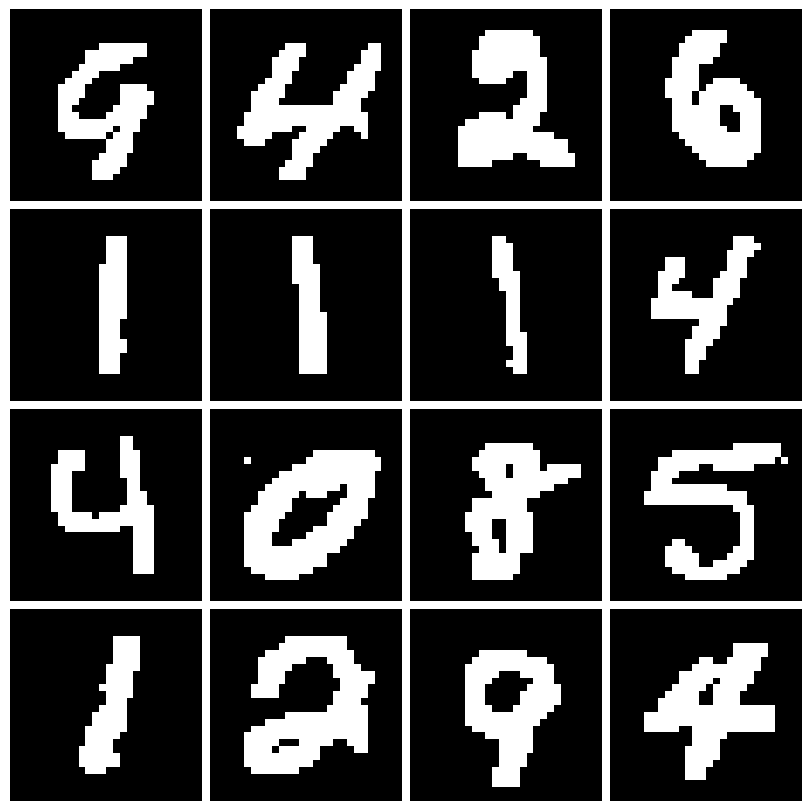

In [370]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8),  layout='constrained')

for i in range(16):
    ax[i // 4, i % 4].imshow(x_hat.cpu().numpy()[i], cmap='Greys_r')
    ax[i // 4, i % 4].axis('off')

We can also observe how the network processes images at different times during the sampling process in order to get an idea of how the images evolve during the generation.

In [21]:
x_0 = get_sample(train_loader)[0][0][0]

Ys = []
Ks = []
Ts = []

# We set t going from 0 to 2/3
for t in np.linspace(0.001, 0.667, 20):
  l, y, k, t_ = bfn.process(x_0[None, :, :, None].to(torch.int64).to(DEVICE), training=False, time=t)
  Ys.append(y.permute(0, 2, 1, 3).cpu().numpy()[0, :, :, 1])
  Ks.append(k.permute(0, 2, 1).cpu().numpy()[0])
  Ts.append(t)

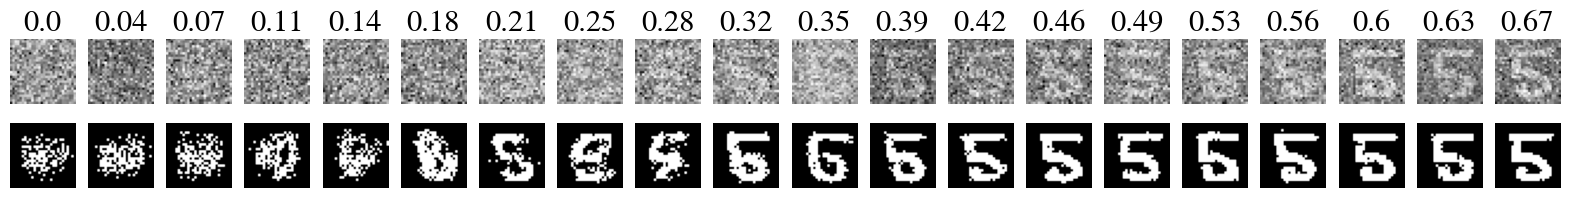

In [22]:
fig, ax = plt.subplots(2, 20, figsize=(20, 2))

for i in range(20):
  ax[0, i].imshow(Ys[i], cmap='Greys_r')
  ax[1, i].imshow(Ks[i], cmap='Greys_r')
  ax[0, i].axis('off')
  ax[1, i].axis('off')

  ax[0, i].set_title(np.round(Ts[i], 2))

As the process evolves, the images are getting clearer and clearer, to finally look like a sample from the training dataset.